

# Predictive Modeling of Food Access  
**Dataset**: Food Access Research Atlas (USDA ERS) 
**Objective**: Predict whether a census tract is “Low Income & Low Access” (LILA) using tract-level features.

---

## 1. Introduction  
Limited access to supermarkets, supercenters, or large grocery stores may make it harder for some people to eat a healthy diet — an important issue in food security and public health. :contentReference[oaicite:2]{index=2}  
In this notebook we will:  
- Load and inspect the data  
- Conduct exploratory data analysis (EDA)  
- Preprocess the data for modelling  
- Build predictive models (logistic regression, random forest, XGBoost)  
- Evaluate performance and interpret results  
- Summarize findings and next steps  

---


## 2. Data Loading & Initial Inspection  
```python

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Load dataset (adjust path)
df = pd.read_csv('FoodAccessResearchAtlas.csv', low_memory=False)

print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe())

Shape: (72531, 147)


,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.68,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72531 entries, 0 to 72530
Columns: 147 entries, CensusTract to TractSNAP
dtypes: float64(126), int64(19), object(2)
memory usage: 81.3+ MB


None

,CensusTract,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
count,7.253100e+04,72531.000000,72531.000000,72531.000000,72531.000000,72506.000000,72506.000000,72531.000000,72531.000000,72531.000000,...,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000,72527.000000
mean,2.782573e+10,0.760626,4256.739022,1609.191821,0.007114,110.121549,2.708677,0.128125,0.279150,0.112228,...,555.197113,3082.337157,536.756160,202.327685,7.445655,40.152316,387.664649,695.979277,143.709736,201.753182
std,1.581647e+10,0.426704,1955.987626,725.676046,0.084046,443.931753,9.570875,0.334231,0.448584,0.315649,...,351.805391,1796.364560,889.118109,435.878339,45.186581,177.378696,529.349680,1119.472739,232.738869,185.760089
min,1.001020e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.212708e+10,1.000000,2899.000000,1108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,320.000000,1848.000000,43.000000,17.000000,0.000000,7.000000,85.000000,88.000000,36.000000,67.000000
50%,2.712979e+10,1.000000,4011.000000,1525.000000,0.000000,7.000000,0.180000,0.000000,0.000000,0.000000,...,497.000000,2914.000000,160.000000,58.000000,1.000000,15.000000,186.000000,243.000000,82.000000,152.000000
75%,4.103900e+10,1.000000,5330.500000,2021.000000,0.000000,64.000000,1.570000,0.000000,1.000000,0.000000,...,718.000000,4118.000000,610.000000,189.000000,5.000000,33.000000,448.000000,751.000000,168.500000,282.000000
max,5.604595e+10,1.000000,37452.000000,16043.000000,1.000000,19496.000000,100.000000,1.000000,1.000000,1.000000,...,17271.000000,28983.000000,16804.000000,10485.000000,3491.000000,9009.000000,8839.000000,15420.000000,6059.000000,2175.000000


In [13]:
target_col = 'LILATracts_1And10'  # adjust as needed

# Convert to integer
df = df.copy()
df[target_col] = df[target_col].astype(int)

# Class balance
print("Class counts:\n", df[target_col].value_counts())
print("Proportion positive class:", df[target_col].mean())


Class counts:
 LILATracts_1And10
0    63238
1     9293
Name: count, dtype: int64
Proportion positive class: 0.12812452606471716


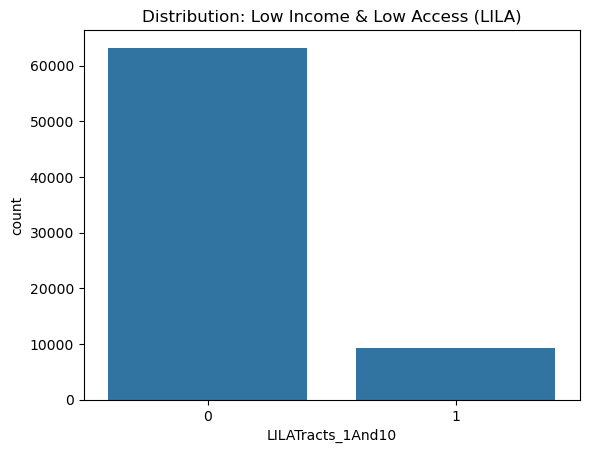

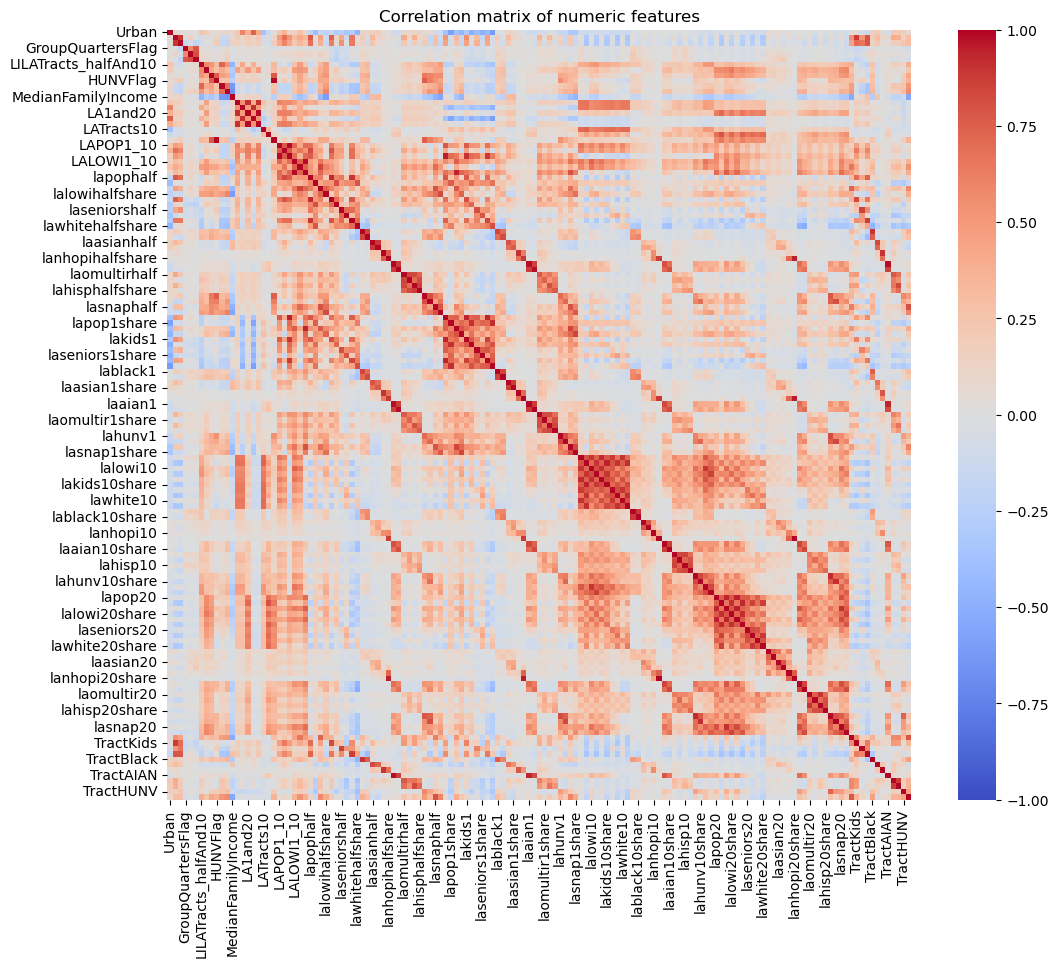

In [15]:
# Distribution of target
sns.countplot(x=target_col, data=df)
plt.title('Distribution: Low Income & Low Access (LILA)')
plt.show()

# Numeric features list
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = [target_col, 'CensusTract']  # adjust id/geo columns
numeric_feats = [c for c in numeric_cols if c not in drop_cols]

# Correlation heatmap (subset for clarity)
corr = df[numeric_feats].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of numeric features')
plt.show()

# Histograms of select predictors
for col in ['PCT_HH_NoVehicle', 'Distance_Supermarket_1Mile', 'PCT_LowIncome', 'PCT_VEHICLE_ACCESS_0'][:4]:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution: {col}')
        plt.show()


In [17]:
# Handle missing values (median impute)
imputer = SimpleImputer(strategy='median')
X_num = imputer.fit_transform(df[numeric_feats])
X_num = pd.DataFrame(X_num, columns=numeric_feats)

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X = pd.DataFrame(X_scaled, columns=numeric_feats)

y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (50771, 143) Test size: (21760, 143)


In [19]:
logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:,1]

print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:",",", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Metrics:
Accuracy: 0.9998621323529412
Precision: 0.9992828970957333
Recall: , 0.9996413199426112
F1-score: 0.9994620763851533
ROC AUC: 0.9996275943616675
Confusion Matrix:
 [[18970     2]
 [    1  2787]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18972
           1       1.00      1.00      1.00      2788

    accuracy                           1.00     21760
   macro avg       1.00      1.00      1.00     21760
weighted avg       1.00      1.00      1.00     21760



In [21]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Metrics:
Accuracy: 0.9999540441176471
Precision: 1.0
Recall: 0.9996413199426112
F1-score: 0.9998206278026905
ROC AUC: 1.0
Confusion Matrix:
 [[18972     0]
 [    1  2787]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18972
           1       1.00      1.00      1.00      2788

    accuracy                           1.00     21760
   macro avg       1.00      1.00      1.00     21760
weighted avg       1.00      1.00      1.00     21760



In [24]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]

print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0
Confusion Matrix:
 [[18972     0]
 [    0  2788]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18972
           1       1.00      1.00      1.00      2788

    accuracy                           1.00     21760
   macro avg       1.00      1.00      1.00     21760
weighted avg       1.00      1.00      1.00     21760



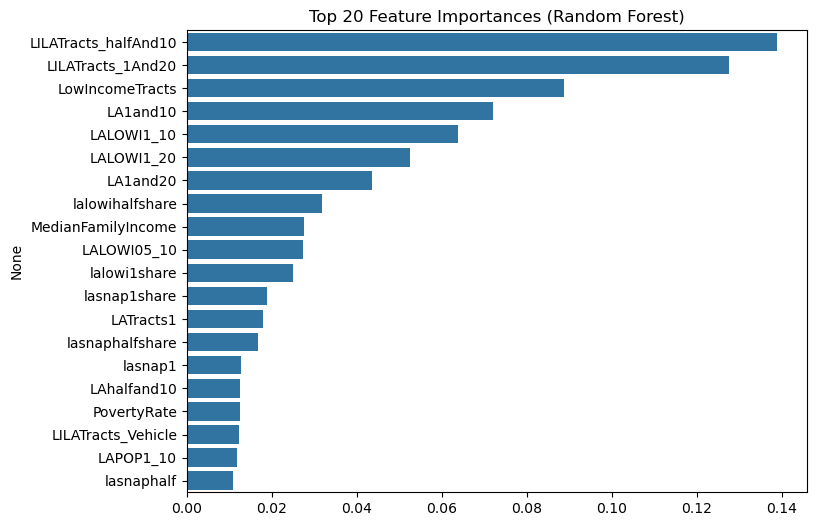

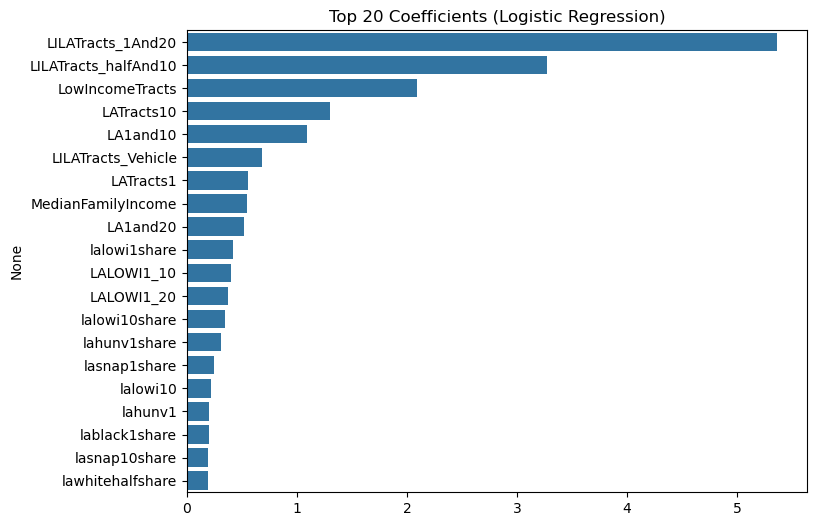

In [26]:
# Feature importances from Random Forest
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=numeric_feats).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()

# Coefficients from Logistic Regression
coeffs = pd.Series(logreg.coef_[0], index=numeric_feats).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title('Top 20 Coefficients (Logistic Regression)')
plt.show()


In [30]:
# Example: after training
model = rf  # e.g., RandomForestClassifier trained
preprocess = scaler  # e.g., your StandardScaler or full pipeline



In [32]:
import pickle

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the preprocessing pipeline
with open("preprocessing.pkl", "wb") as f:
    pickle.dump(preprocess, f)


In [34]:
# Using pickle
with open("model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("preprocessing.pkl", "rb") as f:
    loaded_preprocess = pickle.load(f)

# (Optional) test to make sure predictions work:
X_test_proc = loaded_preprocess.transform(X_test)  # assuming X_test available
y_pred = loaded_model.predict(X_test_proc)
print("Loaded model test accuracy:", accuracy_score(y_test, y_pred))


Loaded model test accuracy: 0.982858455882353
